<a href="https://colab.research.google.com/github/Randon-Myntra-HackerRamp-21/Acne-type/blob/main/Acne_types_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
from tensorflow.keras import layers

In [4]:
!pip install split-folders

import splitfolders
splitfolders.ratio('/content/drive/MyDrive/data/Acne', output="output", seed=1337, ratio=(.8, 0.2)) 

Copying files: 999 files [00:03, 315.23 files/s]


In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/content/output/train/"
test_dir = "/content/output/val/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 798 images belonging to 3 classes.
Found 201 images belonging to 3 classes.


In [7]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

def create_model(model_url, num_classes=3):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL.
    num_classes(int): Number of output neurons in the output layer, 
      should be equal to number of target classes, default = 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,   # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))  # define the input image shape
  # Create our image model
  model = tf.keras.Sequential([
     feature_extractor_layer,    # use the feature extraction layer as the base
     layers.Dense(num_classes, activation="softmax", name="output_layer")   # create our own output layer
  ])
  return model

In [9]:
# Create EfficientNet model
efficientnet_model = create_model(efficientnet_url,
                            num_classes=3)
# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=valid_data)   # name of log files

Epoch 1/5
50/50 [==============================] - 17s 155ms/step - loss: 0.9838 - accuracy: 0.4962 - val_loss: 0.8942 - val_accuracy: 0.5522
Epoch 2/5
50/50 [==============================] - 7s 130ms/step - loss: 0.8641 - accuracy: 0.5815 - val_loss: 0.8297 - val_accuracy: 0.5970
Epoch 3/5
50/50 [==============================] - 7s 132ms/step - loss: 0.8174 - accuracy: 0.6003 - val_loss: 0.7852 - val_accuracy: 0.6667
Epoch 4/5
50/50 [==============================] - 7s 131ms/step - loss: 0.7687 - accuracy: 0.6554 - val_loss: 0.7621 - val_accuracy: 0.6269
Epoch 5/5
50/50 [==============================] - 7s 131ms/step - loss: 0.7314 - accuracy: 0.6817 - val_loss: 0.7393 - val_accuracy: 0.6766


In [10]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


In [11]:
efficientnet_model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [12]:
model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


In [13]:
import pathlib 
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Level_0' 'Level_1' 'Level_2']


In [14]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [15]:
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class & get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]
  
  print('Prediction Probabilities : ', pred[0])

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Prediction Probabilities :  [0.3541107  0.4744522  0.17143711]


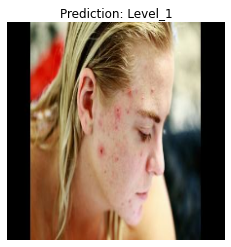

In [17]:
# Make a prediction using model_1
pred_and_plot(model=model, 
              filename="/content/aa-Cover-3lvoms4m2e1nufj2186bcth8v7-20190827114348.jpeg", 
              class_names=class_names)